In [49]:
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
# 链接了多个 OpenMP 运行时库，解决
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.tensorboard import SummaryWriter
# tensorboard 
writer = SummaryWriter()


In [50]:
# 数据及加载
with open('./weather_dataset/Summary of Weather.csv', 'r', encoding='utf-8') as f:
    data = csv.DictReader(f)
    temperatures = [float(row['MaxTemp']) for row in data]

temperatures = np.array(temperatures, dtype=np.float32)
temperatures = np.round(temperatures, 0)

# 数据集拆分
n_steps = 10
temperatures = temperatures[:10000* (n_steps + 1)* 1]
series = temperatures.reshape(10000, n_steps + 1, 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
print(X_train[0,0:10])
X_train.shape, y_train.shape

[[26.]
 [29.]
 [26.]
 [27.]
 [27.]
 [27.]
 [28.]
 [27.]
 [27.]
 [26.]]


((7000, 10, 1), (7000, 1))

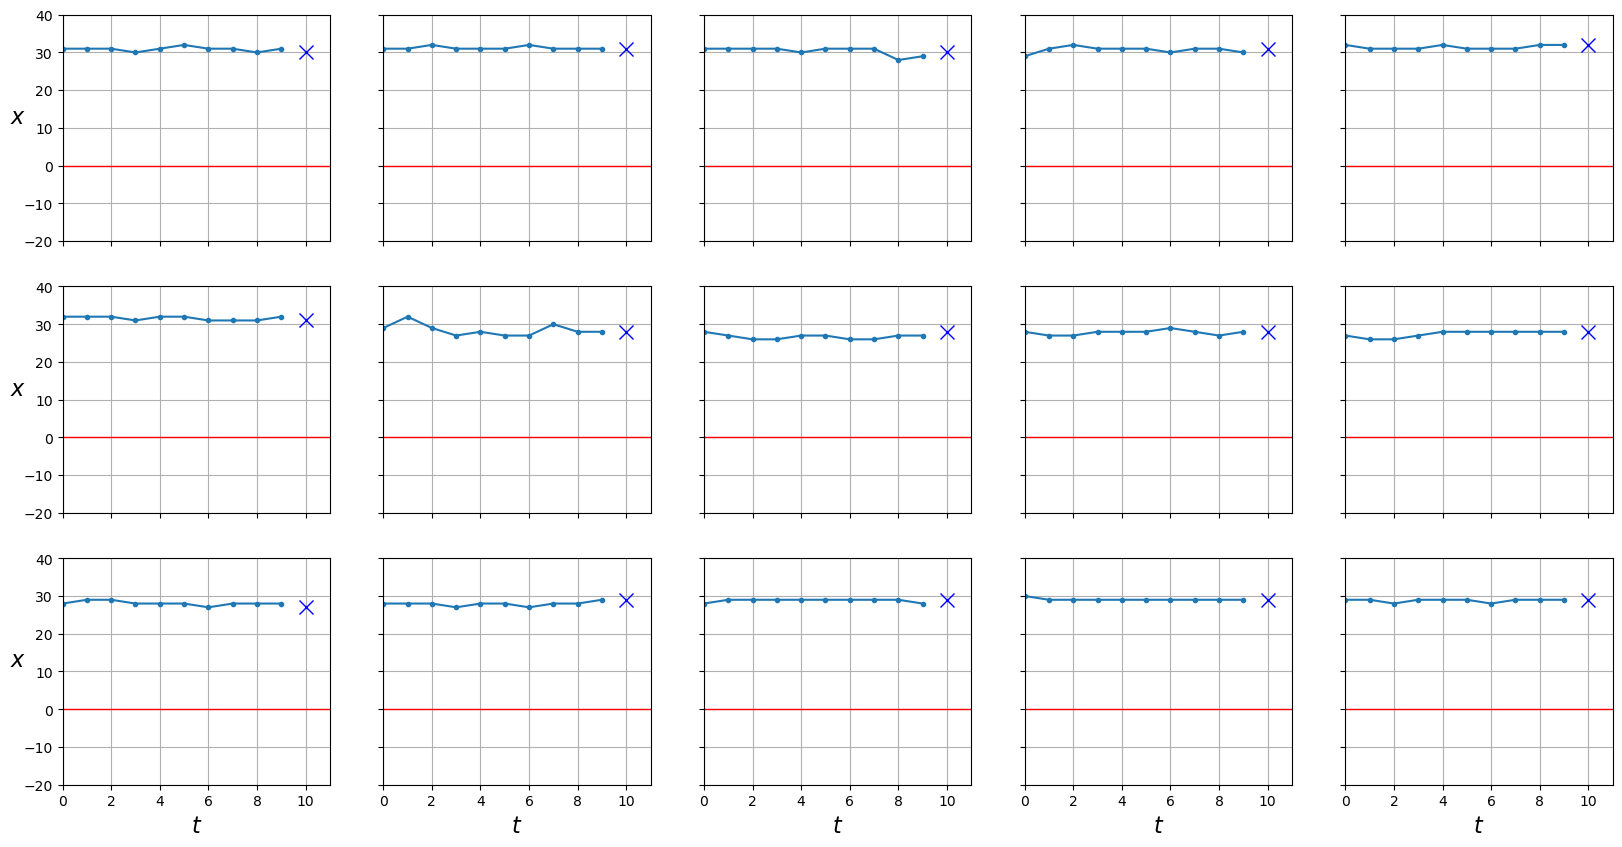

In [51]:


def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    # 设置行数和列数
    r, c = 3, 5
    # 创建子图
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    # 遍历每一行
    for row in range(r):
        # 遍历每一列
        for col in range(c):
            # 设置当前子图
            plt.sca(axes[row][col])
            # 计算当前子图的索引
            ix = col + row*c
            # 绘制原始序列
            plt.plot(series[ix, :], ".-")
            # 如果有真实值，绘制真实值
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            # 如果有预测值，绘制预测值
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            # 如果有预测值的标准差，绘制预测值的上下界
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            # 显示网格线
            plt.grid(True)
            # 绘制水平线
            plt.hlines(0, 0, 100, linewidth=1, colors='red')
            # 设置坐标轴范围
            plt.axis([0, len(series[ix, :])+len(y[ix]), -20, 40])
            # 如果有x轴标签，设置x轴标签
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            # 如果有y轴标签，设置y轴标签
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    # 显示图像
    plt.show()

plot_series(X_test, y_test)

In [52]:

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [53]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.LSTM(input_size=1, hidden_size=100, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(100, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [54]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=20):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            # tensorboard
            writer.add_scalar("train_loss", np.mean(train_loss), epoch)
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
            # tensorboard
        return preds

In [55]:
fit(rnn, dataloader)

loss 4.52012 val_loss 7.05399: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]   


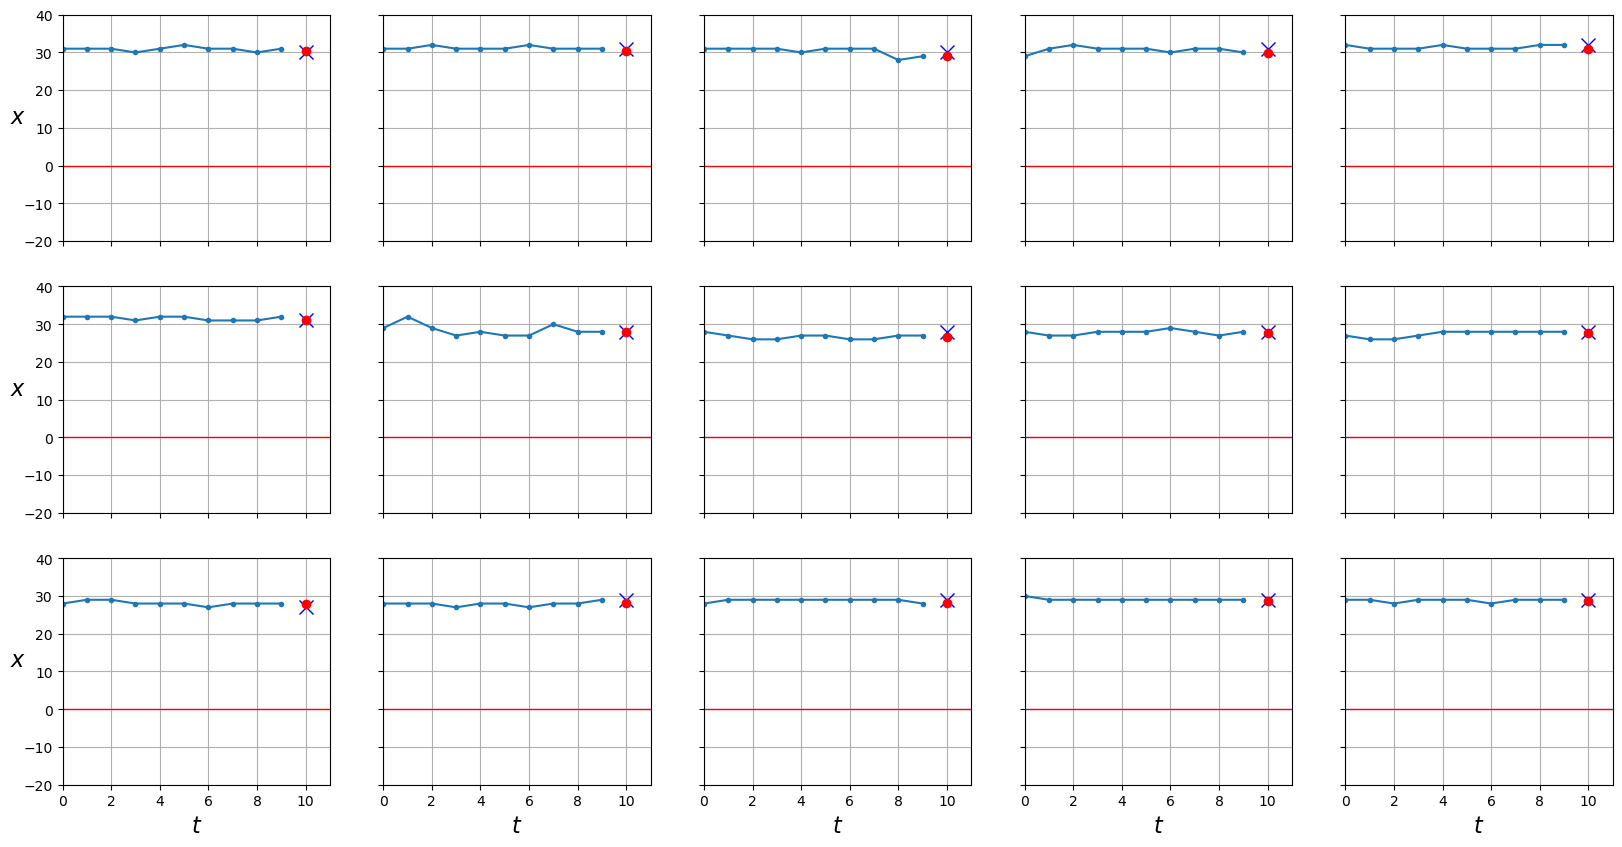

1.5543724298477173

In [56]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())